In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import pickle, os, time

import entropy

basedir, desc, plotsqreg = 'saveddata3/Regression/v1', 'Regression', ['reg',]
#basedir, desc, plotsqreg = 'saveddata3/MNIST/v1', 'MNIST', ['reg',]
#basedir, desc, plotsqreg = 'saveddata3/NoisyClassifier/v1', 'NoisyClassifier', ['reg',]
basedir, desc, plotsqreg = 'saveddata3/NoisyClassifierWine/v2', 'NoisyClassifierWine', ['reg',]
basedir, desc, plotsqreg = 'saveddata3/NoisyClassifierWine/v3d', 'NoisyClassifierWineV3', ['reg',]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
vals = {}
vals['VIB']         = {}
vals['VIB']['reg']  = {'tst': {}, 'trn': {}}
vals['VIB']['sq']   = {'tst': {}, 'trn': {}}
vals['nlIB']        = {}
vals['nlIB']['reg'] = {'tst': {}, 'trn': {}}
vals['nlIB']['sq']  = {'tst': {}, 'trn': {}}

for fname in os.listdir(basedir):
    with open(basedir + '/' + fname, 'rb') as f:
        if fname.endswith('-base') or fname.startswith('_tf_basemodel') or fname=='checkpoint':
            continue
        print(basedir + '/' + fname)
        cfg, saved_data = pickle.load(f)
        sqmode = 'sq' if cfg['squaredIB'] else 'reg'
        losses = np.array([r['trn']['loss'] for r in saved_data])
        lrow = saved_data[len(losses)-10+np.argmin(losses[-10:])]
        #lrow = saved_data[-1]
        var, beta = lrow['noisevar'], lrow['beta']
        _, mode, *_ = fname.split("-",)
        #mode = lrow['mode']
        for r in ['trn','tst']:
            l     = lrow[r]
            mx    = l['activations']
            n, d  = mx.shape
            mcH   = entropy.get_mc_entropy(mx, var)
            hCond = entropy.gaussian_entropy_np(d, var)
            l['Ixt_mc'] = mcH - hCond
            print('%s epoch: %d beta: %0.4f Ixt: %0.2f-%0.2f (%0.2f) Iyt: %0.2f' % 
                  (r, lrow['epoch'], beta, l['Ixt_lb'], l['Ixt'], l['Ixt_mc'], l['Iyt']))
            
            if beta not in vals[mode][sqmode][r] or \
               (l['Ixt_mc'] <= vals[mode][sqmode][r][beta]['Ixt_mc'] and yt >= vals[mode][sqmode][r][beta]['Iyt']):
                vals[mode][sqmode][r][beta] = l
                if False:
                    plt.figure()
                    plt.scatter(mx[:,0], mx[:,1], s=l['noisevar'], alpha=.3)
                    plt.title('beta=%.4f mode=%s'%(beta, mode))
        print()


saveddata3/NoisyClassifierWine/v3d/results-VIB-0.00100-reg-run0
trn epoch: 294 beta: 0.0010 Ixt: 3.21-4.37 (1.33) Iyt: 0.18
tst epoch: 294 beta: 0.0010 Ixt: 3.20-4.35 (1.28) Iyt: 0.17

saveddata3/NoisyClassifierWine/v3d/results-nlIB-0.00100-reg-run0
trn epoch: 293 beta: 0.0010 Ixt: 6.06-7.32 (3.06) Iyt: 0.18
tst epoch: 293 beta: 0.0010 Ixt: 6.03-7.29 (3.05) Iyt: 0.16

saveddata3/NoisyClassifierWine/v3d/results-VIB-0.00193-reg-run0
trn epoch: 296 beta: 0.0019 Ixt: 2.02-3.08 (0.78) Iyt: 0.17
tst epoch: 296 beta: 0.0019 Ixt: 2.02-3.08 (0.78) Iyt: 0.16

saveddata3/NoisyClassifierWine/v3d/results-nlIB-0.00193-reg-run0
trn epoch: 28 beta: 0.0019 Ixt: 5.71-6.96 (3.05) Iyt: 0.16
tst epoch: 28 beta: 0.0019 Ixt: 5.70-6.96 (3.01) Iyt: 0.17



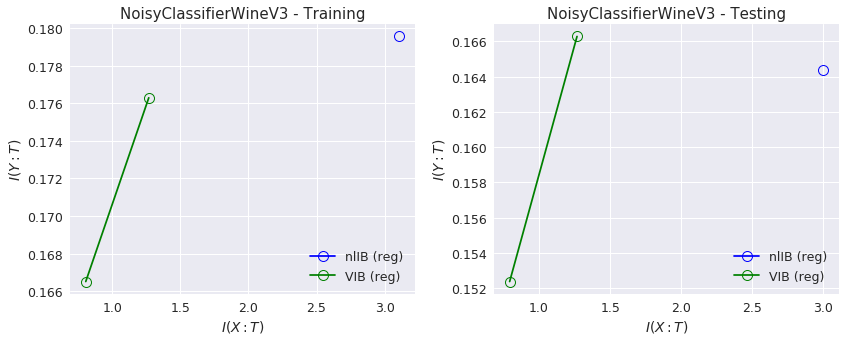

In [7]:
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.25)

plt.figure(figsize=(12,5))
for sqmode in ['reg']:
    for rndx, r in enumerate(['trn','tst']):
        plt.subplot(1,2,rndx+1)
        for mode in ['nlIB', 'VIB']:
            d     = vals[mode][sqmode][r]
            bvals = sorted(d.keys())
            xt    = [d[b]['Ixt'] for b in bvals]
            xtlb  = [d[b]['Ixt_lb'] for b in bvals]
            xtmc  = [d[b]['Ixt_mc'] for b in bvals]
            yt    = [d[b]['Iyt'] for b in bvals]
            if len(xtmc):
                plt.plot(xtmc, yt, ls={'reg':'-','sq':'-'}[sqmode], 
                         color={('nlIB','reg'):'blue', ('nlIB','sq'):'red', ('VIB','reg'):'green', ('VIB','sq'):'purple'}[(mode,sqmode)],
                         marker='o', markersize=10, markerfacecolor='none', markeredgewidth=1,
                         label=mode + " (%s)" % sqmode)
                # plt.fill_betweenx(yt, xtlb, xt, alpha=0.3, label=mode)
        plt.ylabel('$I(Y:T)$')
        plt.xlabel('$I(X:T)$')
        #plt.ylim([0, 1.1*plt.ylim()[1]])
        #plt.xlim([0, 1.1*plt.xlim()[1]])
        plt.legend(loc='lower right')
        plt.title(desc + ' - ' + {'tst':'Testing', 'trn':'Training'}[r])

        #plt.ylim([0, plt.ylim()[1]])
        #plt.xlim([0, plt.xlim()[1]])
        if False and desc == 'MNIST':
            maxv = 1.1*plt.ylim()[1]
            plt.plot([0, maxv], [0,maxv], 'k--', lw=1)
            plt.xlim([0, maxv])
    # Plot optimal Gaussian IB curve (doesn't seem to work well, suspect it has to do with dimensionality)
    # 
    # with open('data/regression-10-100.pkl', 'rb') as f:
    #     data = pickle.load(f)
    # mx = np.hstack([data[r+'_data'], data[r+'_labels']])
    # xdims = data[r+'_data'].shape[1]
    # xs, ys = entropy.get_gib_curve(np.cov(mx.T.astype('float64')), xdims)
    # #print(xs, ys)
    # plt.plot(xs/10, ys, c='k',label='Optimal')
    

plt.tight_layout()
plt.savefig('plots/%s.pdf'%desc)
    
    

In [4]:

#print(vals['nlIB']['trn'][.05])
plt.figure()
plt.scatter(*vals['VIB']['tst'][.05]['act'].T, s=vals['VIB']['tst'][.05]['noisevar'], alpha=0.1)
plt.figure()
plt.scatter(*vals['nlIB']['tst'][.05]['act'].T, s=vals['nlIB']['tst'][.05]['noivarvar'], alpha=0.1)
#print(get_mc(vals['nlIB']['trn'][.95]['noisevar'])


KeyError: 'tst'

<Figure size 432x288 with 0 Axes>

In [ ]:
covXY = np.cov(mx.T.astype('float64'))
covX = covXY[:xdims,:xdims]
covY = covXY[xdims:,xdims:]
covXgY = covX - covXY[:xdims,xdims:].dot(np.linalg.inv(covY)).dot(covXY[xdims:,:xdims])
mainMx = covXgY.dot(np.linalg.inv(covX))

evecs, evals = np.linalg.eig(mainMx)
evecs = np.abs(evecs) # print(evecs, np.real(evecs))
#print(evecs.min(), evecs.max())
assert(np.all(evecs >= -1e-5) and np.all(evecs <= 1+1e-5))
ix = np.argsort(evecs)
sorted_evecs = evecs[ix]
sorted_evecs


In [ ]:
vals['nlIB']['reg']['trn']